In [1]:
import numpy as np
import pandas as pd
import os, pickle, itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy.random import seed
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Lambda, Input, Conv1D, LSTM
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D, Dropout, RepeatVector
from tensorflow.keras.layers import GRU, Bidirectional, concatenate, Dense, Embedding
from tensorflow.keras.layers import BatchNormalization, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

In [2]:
# fixate the random state
random_state = 1337
seed(random_state)
tf.random.set_seed(random_state)

In [3]:
df = pd.read_csv("dataset.csv")

# fit the tokenizer
tokenizer = Tokenizer(num_words=None, filters=None, lower=False, char_level=True, oov_token='<UNK>')
tokenizer.fit_on_texts(df.word)
total_chars = len(tokenizer.word_index) + 1

# tokenize and pad everything, max len of 32
text_sequences = tokenizer.texts_to_sequences(df.word)
text_padded = pad_sequences(text_sequences, padding='post', truncating='post', maxlen=32)

# we want the word index so we can recreate the tokenization manually for the Docker app
print(tokenizer.word_index)

# split into train/test
y = df.is_password
X_train, X_test, y_train, y_test = train_test_split(text_padded, y, test_size=0.1, shuffle=True, random_state=random_state)

{'<UNK>': 1, 'e': 2, 'i': 3, 'a': 4, 'n': 5, 't': 6, 'r': 7, 'o': 8, 's': 9, 'c': 10, 'l': 11, 'A': 12, 'E': 13, 'd': 14, 'u': 15, 'm': 16, 'p': 17, 'I': 18, 'S': 19, 'R': 20, 'O': 21, 'N': 22, 'g': 23, 'T': 24, '-': 25, 'L': 26, 'h': 27, 'y': 28, 'C': 29, 'b': 30, 'f': 31, 'M': 32, 'v': 33, 'D': 34, '1': 35, 'U': 36, 'H': 37, 'P': 38, 'k': 39, '2': 40, '0': 41, 'B': 42, 'G': 43, 'w': 44, 'Y': 45, 'K': 46, '3': 47, '9': 48, 'F': 49, '.': 50, ',': 51, '4': 52, '8': 53, 'V': 54, '5': 55, '7': 56, '6': 57, 'W': 58, 'j': 59, 'x': 60, 'z': 61, 'J': 62, 'q': 63, 'Z': 64, '_': 65, "'": 66, ':': 67, 'X': 68, 'Q': 69, '/': 70, ')': 71, '(': 72, '"': 73, '!': 74, ';': 75, '*': 76, '@': 77, '\\': 78, ']': 79, '?': 80, '[': 81, '<': 82, '>': 83, '=': 84, '#': 85, '&': 86, '$': 87, '+': 88, '%': 89, '`': 90, '~': 91, '^': 92, '{': 93, '}': 94, '|': 95}


In [4]:
# build the model

model_name = "bilstm"

embedding_dimension = 20
dropout = 0.5
cells = 200

model = Sequential()
model.add(Embedding(total_chars, embedding_dimension, input_length=32, mask_zero=True))
model.add(Bidirectional(LSTM(cells)))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

metrics = [
    "accuracy",
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall")
]

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=metrics
)

print(model.summary())
tf.keras.utils.plot_model(model, f"{model_name}_model.png", show_shapes=True)

# checkpoint path for early stopping
checkpoint_path = f"{model_name}_checkpoint/cp.ckpt"

# path to save the final full model
save_path = f"{model_name}_full"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 20)            1920      
                                                                 
 bidirectional (Bidirectiona  (None, 400)              353600    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 355,921
Trainable params: 355,921
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
# early stopping for regularization
#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, min_delta=.001, verbose=1)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
mc = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True, verbose=1)

# fit model using class weights to minimize false positives
history = model.fit(
    X_train,
    y_train,
    validation_split=.1,
    batch_size=2048,
    epochs=100,
    callbacks=[es, mc],
    verbose=1,
    class_weight = {0: 0.9, 1: 0.1}
)

Epoch 1/100
1582/1583 [============================>.] - ETA: 0s - loss: 0.0562 - accuracy: 0.8653 - fn: 414368.0000 - fp: 21913.0000 - tn: 1598038.0000 - tp: 1205617.0000 - precision: 0.9821 - recall: 0.7442
Epoch 00001: val_accuracy improved from -inf to 0.90089, saving model to bilstm_checkpoint\cp.ckpt
1583/1583 [==============================] - 168s 98ms/step - loss: 0.0562 - accuracy: 0.8653 - fn: 414373.0000 - fp: 21913.0000 - tn: 1598064.0000 - tp: 1205650.0000 - precision: 0.9821 - recall: 0.7442 - val_loss: 0.2759 - val_accuracy: 0.9009 - val_fn: 33817.0000 - val_fp: 1861.0000 - val_tn: 177985.0000 - val_tp: 146337.0000 - val_precision: 0.9874 - val_recall: 0.8123
Epoch 2/100
1582/1583 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9150 - fn: 259837.0000 - fp: 15507.0000 - tn: 1604432.0000 - tp: 1360160.0000 - precision: 0.9887 - recall: 0.8396
Epoch 00002: val_accuracy improved from 0.90089 to 0.92052, saving model to bilstm_checkpoint\cp.ckpt
1583/

In [6]:
val_max_index = np.argmax(history.history["val_accuracy"])
print(f"Best epoch              : {val_max_index}")
print(f"    validation accuracy : {round(history.history['val_accuracy'][val_max_index], 5)}")
print(f"    validation tn       : {int(history.history['val_tp'][val_max_index])}")
print(f"    validation fp       : {int(history.history['val_fp'][val_max_index])}")
print(f"    validation fn       : {int(history.history['val_fn'][val_max_index])}")
print(f"    validation tp       : {int(history.history['val_tp'][val_max_index])}")

Best epoch              : 65
    validation accuracy : 0.98992
    validation tn       : 177184
    validation fp       : 660
    validation fn       : 2970
    validation tp       : 177184


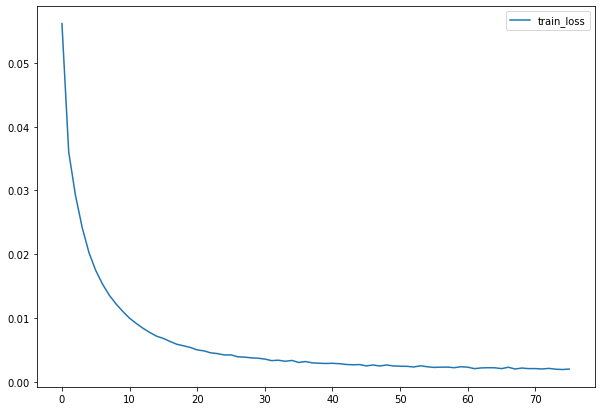

In [7]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='train_loss')
plt.legend()
plt.show()

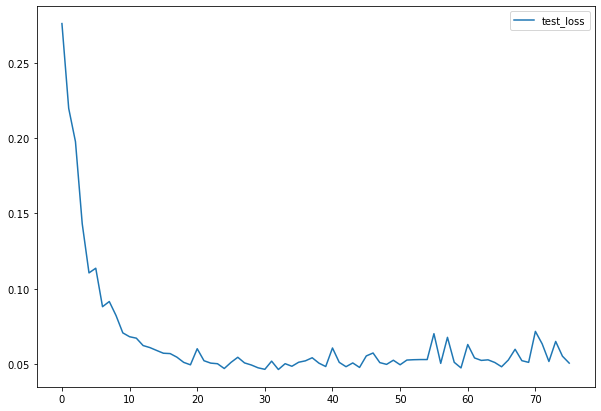

In [8]:
plt.figure(figsize=(10,7))
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()

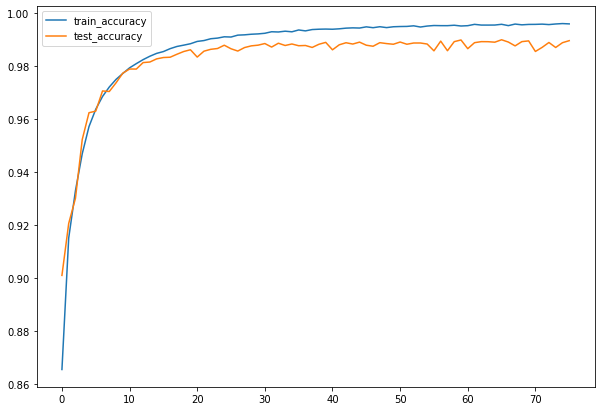

In [9]:
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.legend()
plt.show()

INFO:tensorflow:Assets written to: bilstm_full\assets


INFO:tensorflow:Assets written to: bilstm_full\assets


12500/12500 [==============================] - 202s 16ms/step - loss: 0.0480 - accuracy: 0.9900 - fn: 3281.0000 - fp: 731.0000 - tn: 199446.0000 - tp: 196542.0000 - precision: 0.9963 - recall: 0.9836

------------------
loss       :  0.04804224148392677
tn         :  199446.0
fp         :  731.0
fn         :  3281.0
tp         :  196542.0
------------------
accuracy   :  0.9899700284004211
precision  :  0.9962944984436035
recall     :  0.983580470085144
------------------
F1 score.     :  0.9898966618590025
------------------


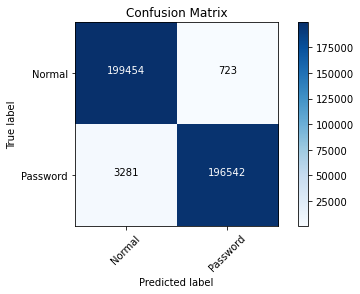

In [10]:
# load the best checkpoint weights
model.load_weights(checkpoint_path)

# save the model to a full format
model.save(save_path)

# get final metrics
reconstructed_model = tf.keras.models.load_model(save_path)


def display_confusion_matrix(y_test, pred_test):
    """
    Displays a nice and pretty confusion matrix for our data set.
    """
    plt.figure()
    classes = ['Normal', 'Password']
    cm = confusion_matrix(y_test, pred_test)
    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


loss, accuracy, fn, fp, tn, tp, precision, recall = reconstructed_model.evaluate(X_test, y_test)

print('\n------------------')
print('loss       : ', loss)
print('tn         : ', tn)
print('fp         : ', fp)
print('fn         : ', fn)
print('tp         : ', tp)
print('------------------')
print('accuracy   : ', accuracy)
print('precision  : ', precision)
print('recall     : ', recall)
print('------------------')

f1 = (2 * precision * recall) / (precision + recall)
print("F1 score.     : ", f1)
print('------------------')

pred_test = model.predict(X_test)

display_confusion_matrix(y_test, np.rint(pred_test))